In [1]:
from chemfit import Chemfit, ModelGridInterpolator
from chemfit.grid import Grid7
from chemfit.instrument import PFS
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
# We configure chemfit to use Grid7 models and set the spectrograph configuration to PFS
cf = Chemfit()
cf.initialize(Grid7(), PFS())

# Specify path to Grid7 models (the directory containing "grid7" and "gridie")
# Alternatively, this definition may be moved to settings/local/Grid7.py (untracked)
cf.settings['griddir'] = '...'

Generate a synthetic observation at given stellar parameters:

In [3]:
# Stellar parameters
params = {'teff': 4000, 'logg': 1.5, 'zscale': -1.0, 'alpha': 0.3}

# Interpolate the model grid
interpolator = ModelGridInterpolator(cf, resample = False)
model_wl, model_flux = interpolator(params)

# Simulate observation with PFS in blue and red arms with medium resolution
wl, flux = cf.simulate_observation(model_wl, model_flux, detector_wl = ['blue', 'red_mr'], combine = False)

# Generate noise with SNR=15
SNR = 15
ivar = {}
for arm in flux:
    sigma = flux[arm] / SNR
    ivar[arm] = sigma ** -2.0
    flux[arm] = np.random.normal(flux[arm], sigma)

/home/dobos/project/ga_chemfit/python/chemfit/chemfit.py:109: UserWarning: In spectrograph arm blue the model does not cover the full wavelength range of the detector. Affected bins were set to np.nan
  warnings.warn(message)


Run the model fit using gradient descent:

In [4]:
# Initial guesses
initial = {'teff': 5000, 'logg': 2.0, 'zscale': 0.0, 'alpha': 0.0}

# Run the fitter
fit_grad = cf.chemfit(wl, flux, ivar, initial, method = 'gradient_descent')

print('Best-fit parameters:', fit_grad['fit'])
print('Errors:', fit_grad['errors'])

Best-fit parameters: {'zscale': -1.0790182487073976, 'alpha': 0.3535985438284658, 'teff': 3931.973313610394, 'logg': 1.2808561282594468}
Errors: {'zscale': 0.10679286683102852, 'alpha': 0.18972499134484833, 'teff': 98.47570230894223, 'logg': 0.13443791727950538}


Run the model fit using MCMC:

In [5]:
fit_mcmc = cf.chemfit(wl, flux, ivar, initial, method = 'mcmc')

print('Best-fit parameters:', fit_mcmc['fit'])
print('Errors:', fit_mcmc['errors'])

100%|██████████| 5000/5000 [07:19<00:00, 11.37it/s]


Best-fit parameters: {'zscale': -1.075577796264803, 'alpha': 0.35349077814204993, 'teff': 3935.9469262457387, 'logg': 1.2899632319892196}
Errors: {'zscale': 0.046392257210386804, 'alpha': 0.03717501198250907, 'teff': 31.271321952554555, 'logg': 0.10868389558046297}


Generate the corner of the MCMC posteriors:

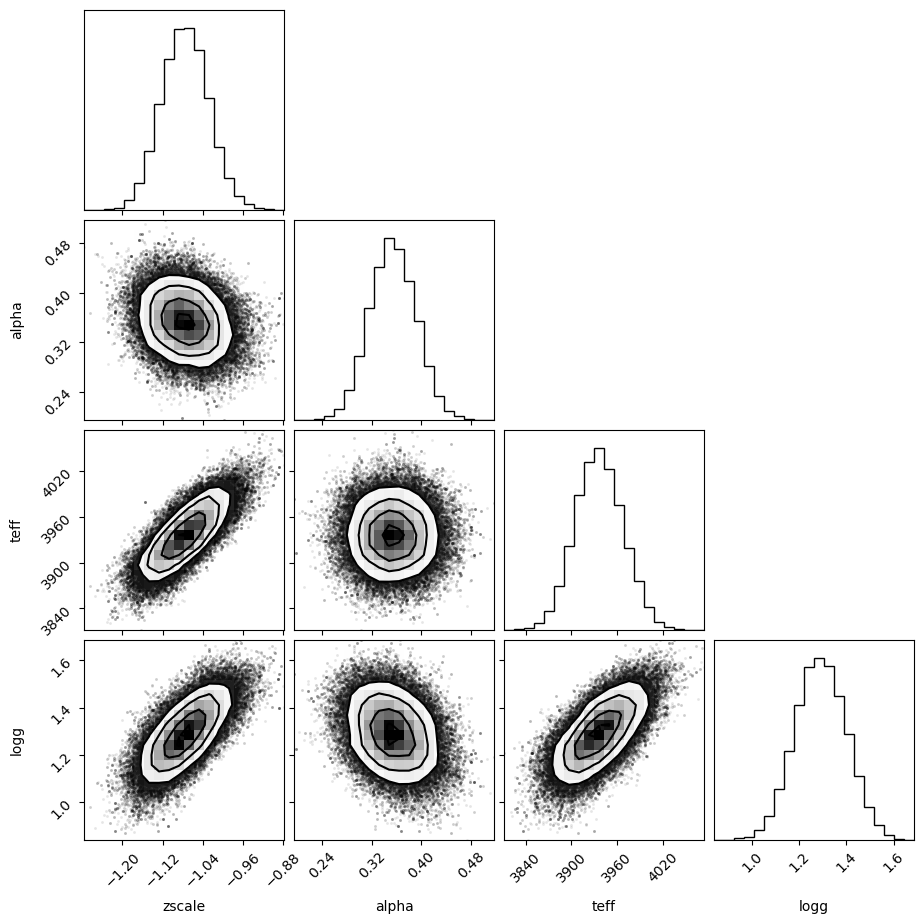

In [6]:
import corner

chain = fit_mcmc['extra']['chain'][500:,:,:]
flatchain = chain[:,:,:].reshape(chain.shape[0] * chain.shape[1], -1)
fig = corner.corner(flatchain, labels = cf.settings['fit_dof']);

Plot the best-fit spectrum:

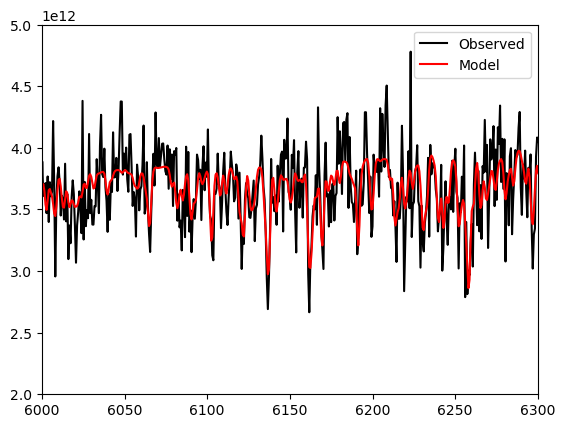

In [7]:
plt.plot(fit_mcmc['extra']['observed']['wl'], fit_mcmc['extra']['observed']['flux'], 'k-', label = 'Observed')
plt.plot(fit_mcmc['extra']['model']['wl'], fit_mcmc['extra']['model']['cont'] * fit_mcmc['extra']['model']['flux'], 'r-', label = 'Model')

plt.xlim(6000, 6300)
plt.ylim(2e12, 5e12)
plt.legend()